In [ ]:
#Esse notebook tem o objetivo de fazer uma análise de emoções em frases em inglês
#Fonte dos dados: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [58]:
!pip install wordcloud

     -------------------------------------- 300.4/300.4 kB 4.6 MB/s eta 0:00:00


In [2]:
df_treino = pd.read_csv("dataset/train.csv")
df_teste = pd.read_csv("dataset/test.csv")
df_val = pd.read_csv("dataset/val.csv")

In [3]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [4]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [5]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
classes = df_treino['emotion'].unique()
print("Classes presentes: ",classes)

print("Quantidade de cada emoção: \n", df_treino['emotion'].value_counts())

percentual_emotion = (df_treino['emotion'].value_counts() / len(df_treino)) * 100
print("Porcentagem de cada emoção: \n",percentual_emotion)

Classes presentes:  ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
Quantidade de cada emoção: 
 joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64
Porcentagem de cada emoção: 
 joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: emotion, dtype: float64


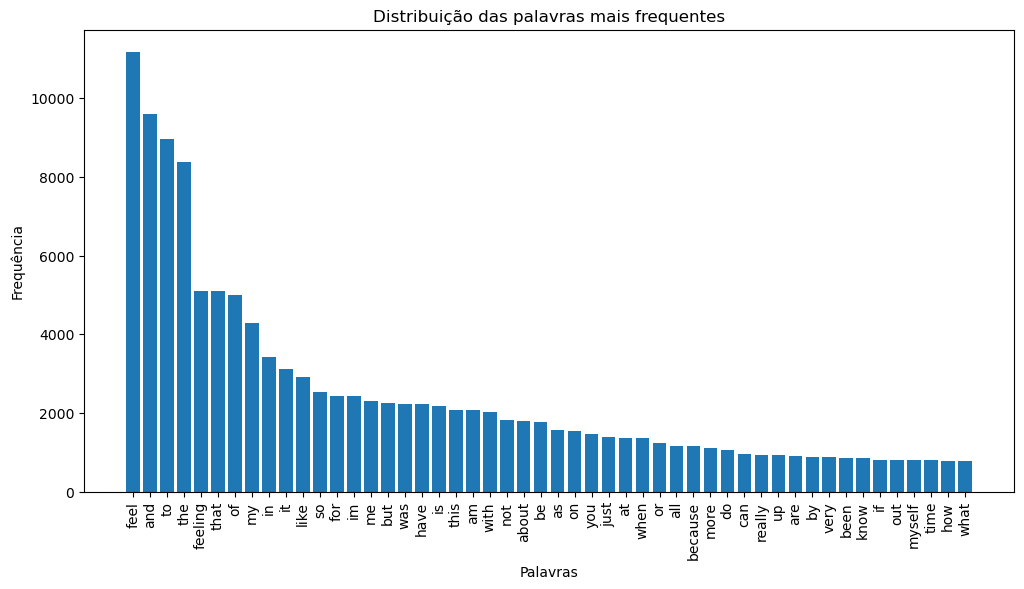

In [7]:
# Converte o texto em bag-of-words (frequência de palavras)
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df_treino['text'])
word_counts = X_counts.toarray().sum(axis=0)

# Ordena as palavras pela frequência
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
words_freq_sorted = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)

# Plota as 50 palavras mais frequentes
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in words_freq_sorted[:50]], [word[1] for word in words_freq_sorted[:50]])
plt.xticks(rotation=90)
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title("Distribuição das palavras mais frequentes")
plt.show()


#### Pré-processamento do texto

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')  # Necessário para a tokenização

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    #Garante que os textos estarão em minusculas
    text = text.lower()
    #remove núrmeros se houver
    text = re.sub(r'\d+', '', text)
    #remove pontuações
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Transforma os textos em tokens
    tokens = word_tokenize(text)
    #Remove stop_words e lemantiza
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
treino = df_treino['text'].apply(preprocess_text)
teste = df_teste['text'].apply(preprocess_text)
val = df_teste['text'].apply(preprocess_text)

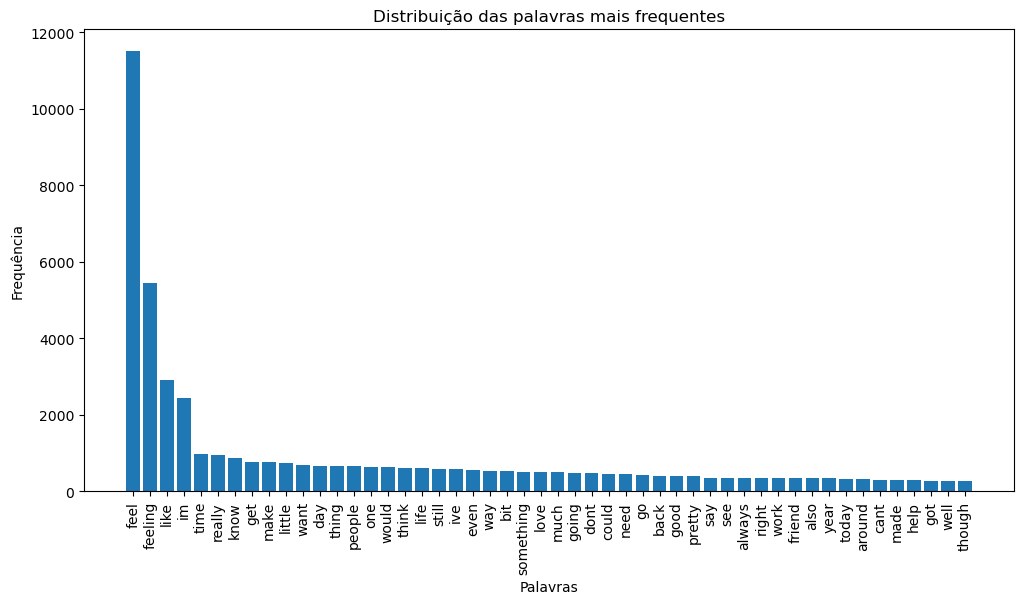

In [10]:
# Converte o texto em bag-of-words (frequência de palavras)
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(treino)
word_counts = X_counts.toarray().sum(axis=0)

# Ordena as palavras pela frequência
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
words_freq_sorted = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)

# Plota as 50 palavras mais frequentes
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in words_freq_sorted[:50]], [word[1] for word in words_freq_sorted[:50]])
plt.xticks(rotation=90)
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title("Distribuição das palavras mais frequentes")
plt.show()


#### Nuvem de palavras

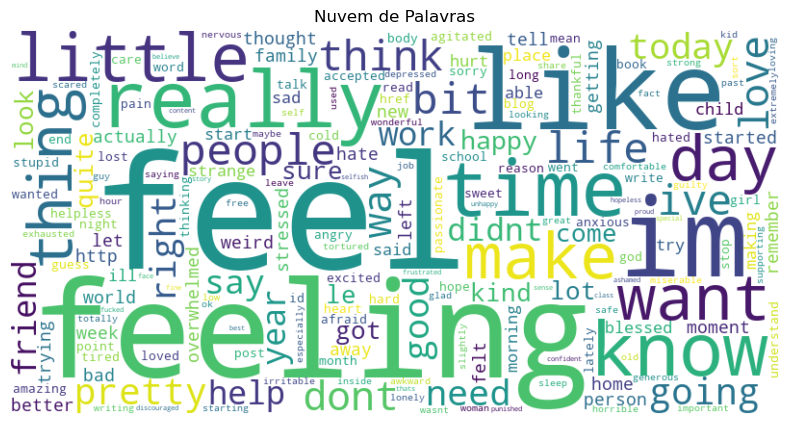

In [11]:
# Vetoriza os textos para obter a frequência das palavras
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(treino)

# Obtém a frequência das palavras
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

# Gera a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(word_freq)

# Exibe a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()


#### Vetorização (TF-IDF)

In [26]:
vectorizer = TfidfVectorizer(max_features = 4200)
treino_tfidf = vectorizer.fit_transform(treino)
val_tfidf = vectorizer.fit_transform(val)
teste_tfidf = vectorizer.fit_transform(teste)


#### Treinado o modelo Naive Bayes

In [ ]:
classes_treino = df_treino['emotion']
model = MultinomialNB()
model.fit(treino_tfidf, classes_treino)

MultinomialNB(alpha=2.0)

In [40]:
#Treino
pred_treino = model.predict(treino_tfidf)
accuracy_treino = accuracy_score(classes_treino, pred_treino)
print(f"Acurácia no conjunto de treino: {accuracy_treino:.4f}")
print(classification_report(classes_treino, pred_treino))

Acurácia no conjunto de treino: 0.7522
              precision    recall  f1-score   support

       anger       0.96      0.54      0.69      2159
        fear       0.94      0.44      0.60      1937
         joy       0.69      0.99      0.81      5362
        love       0.99      0.14      0.25      1304
     sadness       0.75      0.97      0.85      4666
    surprise       1.00      0.01      0.02       572

    accuracy                           0.75     16000
   macro avg       0.89      0.52      0.54     16000
weighted avg       0.81      0.75      0.71     16000



In [41]:
#Validação
classes_val = df_val['emotion']
pred_val = model.predict(val_tfidf)
accuracy_val = accuracy_score(classes_val, pred_val)
print(f"Acurácia no conjunto de validação: {accuracy_val:.4f}")
print(classification_report(classes_val, pred_val))

Acurácia no conjunto de validação: 0.2855
              precision    recall  f1-score   support

       anger       0.13      0.07      0.09       275
        fear       0.08      0.05      0.06       212
         joy       0.34      0.53      0.42       704
        love       0.17      0.02      0.04       178
     sadness       0.26      0.30      0.28       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.29      2000
   macro avg       0.16      0.16      0.15      2000
weighted avg       0.23      0.29      0.25      2000



In [42]:
#Teste
classes_teste = df_teste['emotion']
pred_teste = model.predict(teste_tfidf)
accuracy_teste = accuracy_score(classes_teste, pred_teste)
print(f"Acurácia no conjunto de validação: {accuracy_teste:.4f}")
print(classification_report(classes_teste, pred_teste))

Acurácia no conjunto de validação: 0.3180
              precision    recall  f1-score   support

       anger       0.16      0.08      0.11       275
        fear       0.15      0.08      0.11       224
         joy       0.37      0.57      0.45       695
        love       0.04      0.01      0.01       159
     sadness       0.31      0.34      0.32       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.32      2000
   macro avg       0.17      0.18      0.17      2000
weighted avg       0.26      0.32      0.28      2000



O modelo no conjunto de dados de treino apresentou uma acurácia de 82.8%. Mas obteve uma queda drástica na validação(25.3%) e teste (29.2%), que significa que o modelo está memorizando o conjunto de dados de treino e não generalizando bem novos dados, ou seja, o modelo está com Overfitting.
Motivos que podem estar causando isso:
- As classes "love" e "surprise" têm recall muito baixo, que indica que o modelo tem dificuldade em identificalos corretamente. Isso pode estar sendo causado pois essas classes têm poucas amostras de "surprise"(572 no treino, 66 no teste) e "love" (1304 no treino, 159 no teste), dificultando um aprendizado equilibrado.
- O Naive Bayes pode estar assumindo simplificações muito fortes sobre os dados.
- Por estar usando TF-IDF, pode estar perdendo algumas relações semânticas entre palavras. 

Para tentar resolver esses problemas e melhorar o modelo, tomaram as seguintes atitudes:
- Trocar o TF_IDF por Word2Vec, para representações vetoriais que capturam o significado das palavras.
- Adicionar Laplace smoothing para reguralizar o modelo e evitar overfitting

In [43]:
from gensim.models import Word2Vec

In [ ]:
word2vec_model = Word2Vec(treino, vector_size = 100, window=5, min_count=2, workers=4)